# Step Size Analysis (step_size=0.05)

In [1]:
%matplotlib inline

import glob
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import scipy
import sys

from collections import defaultdict
from datetime import datetime
from typing import Any, Dict, List, Tuple, TypedDict

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.constants import fMRIData
from feeg_fmri_sync.models import HemodynamicModel
from feeg_fmri_sync.plotting import (
    plot_all_search_results,
    plot_all_search_results_2d,
    plot_all_search_results_one_graph,
    plot_local_minima
)
from feeg_fmri_sync.search import get_suitable_range, search_voxels
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
    get_est_hemodynamic_response,
    get_ratio_eeg_freq_to_fmri_freq,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel, VectorizedSumEEGHemodynamicModel


from tests.helpers import (
    load_test_eeg_with_nans,
    load_test_eeg_without_nans,
    load_simulated_raw_fmri,
    generate_downsampled_simulated_fmri,
    generate_summed_simulated_fmri,
)

In [2]:
class ModelToFMRI(TypedDict):
    name: str
    fmri_data_options: Dict[str, fMRIData]
    fmri_to_plot: List[str]

In [3]:
try_to_reuse = True

## Initialize constants for Hemodynamic Modeling

In [4]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_tr_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.25
expected_tau=1.25
expected_alpha=2

time_steps = np.arange(hemodynamic_response_window*sample_freq + 1) / sample_freq
hrf = get_est_hemodynamic_response(time_steps, expected_delta, expected_tau, expected_alpha)
r_fmri = get_ratio_eeg_freq_to_fmri_freq(sample_freq, tr)

In [5]:
# eeg data types to use - with or without missing data
# Data will always be estimated without missing data
eeg_data_options = {
    'without_nans': load_test_eeg_without_nans(sample_frequency=sample_freq),
    'with_nans': load_test_eeg_with_nans(sample_frequency=sample_freq),
}

# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = {
    VectorizedHemodynamicModel: {
        'name': 'downsample',
        'fmri_data_generator': generate_downsampled_simulated_fmri
    }
}

## Display Generated Noise against Simulated Ground Truth

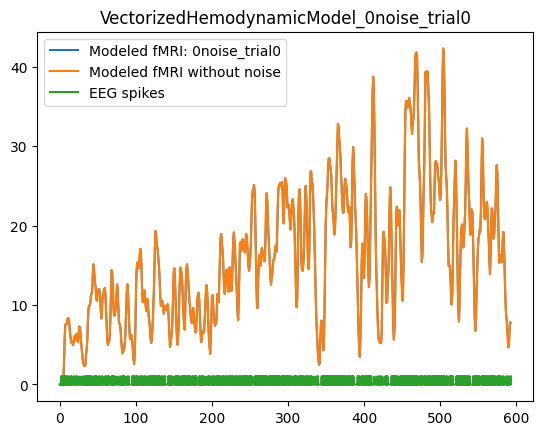

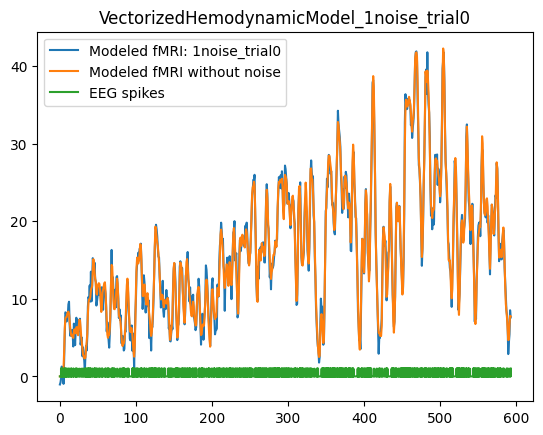

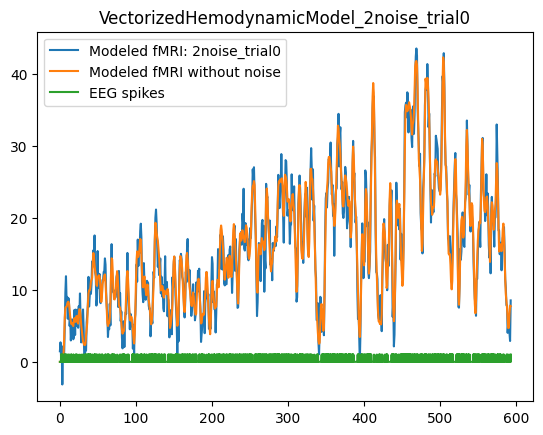

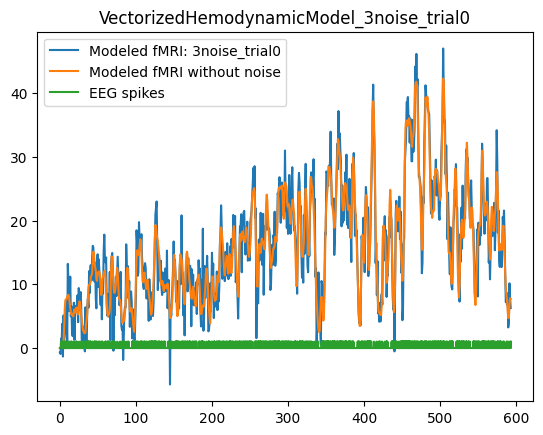

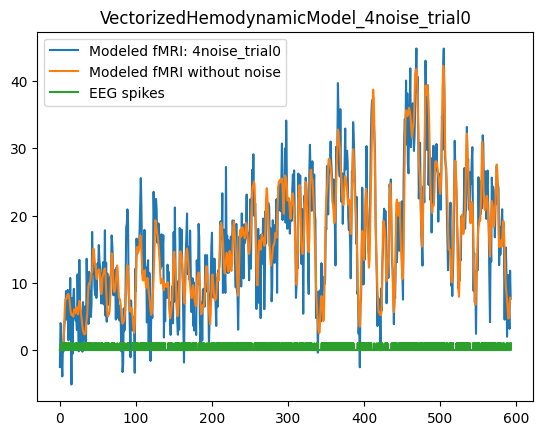

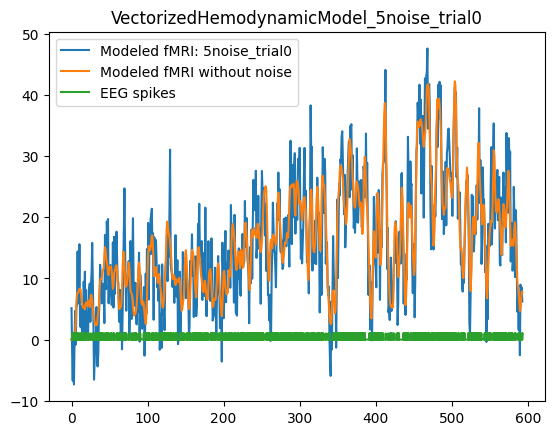

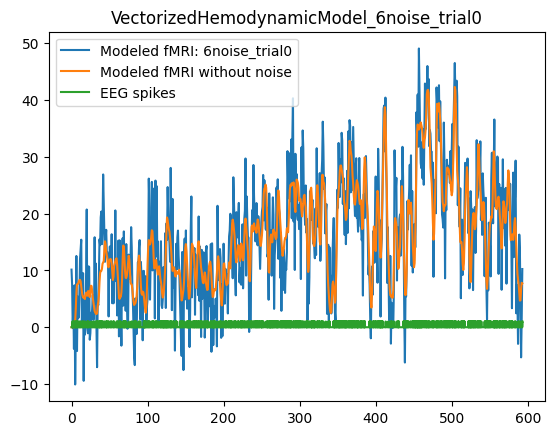

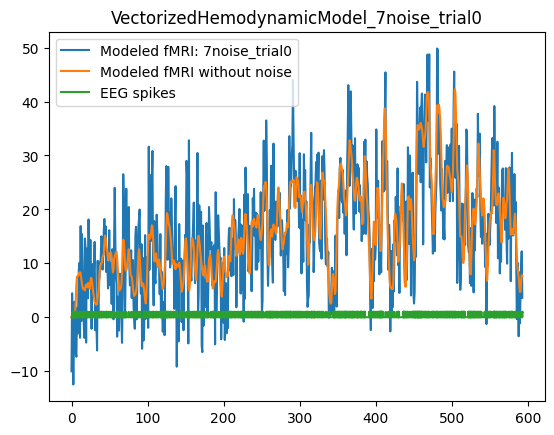

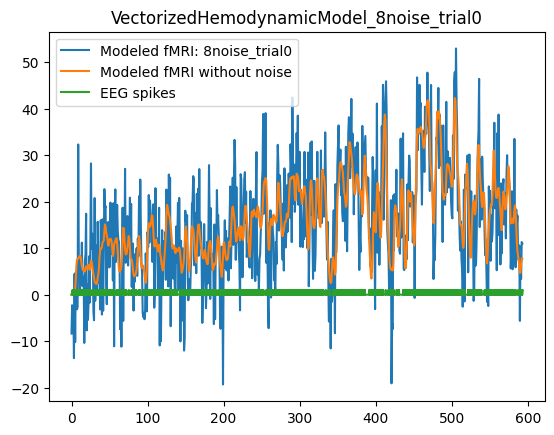

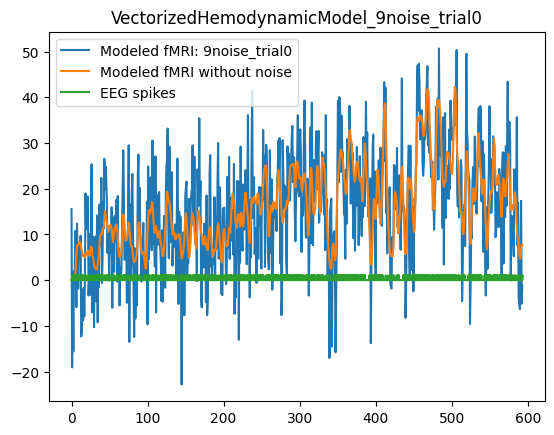

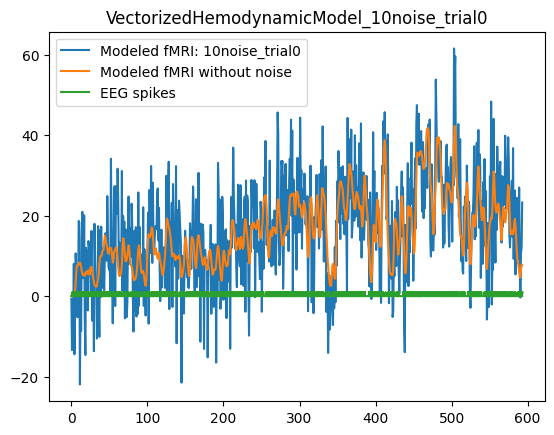

In [6]:
model_to_fmri = dict()

for model, attrs in models_to_test.items():
    fmri_data_options = {}
    fmri_to_plot = []
    name = f'0noise_trial0'
    fmri_data_options[name] = attrs['fmri_data_generator'](
        tr, 
        r_fmri, 
        eeg_data_options['without_nans'],
        hrf,
        0,
        plot=plot_generated_data,
        title=f'{model.__name__}_{name}',
        name = name,
    )
    if plot_perfect_comparison:
        fmri_to_plot.append(name)
    for trial in range(num_trials):
        for noise in noise_range:
            name = f'{noise}noise_trial{trial}'
            fmri_data_options[name] = attrs['fmri_data_generator'](
                tr, 
                r_fmri, 
                eeg_data_options['without_nans'],
                hrf,
                noise,
                plot=plot_generated_data if trial==0 else False,
                title=f'{model.__name__}_{name}',
                name=name
            )
            if noise in noises_to_plot and trial < num_trials_to_plot:
                fmri_to_plot.append(name)
    model_to_fmri[model] = ModelToFMRI(
        name=attrs['name'],
        fmri_data_options=fmri_data_options,
        fmri_to_plot=fmri_to_plot
    )


In [7]:
step_size = 0.05

filename_substring = f'effect_of_step_size_{step_size}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.25, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.25, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



In [8]:
models = {}
for hemodynamic_model in model_to_fmri:
    fmri_names = [fmri_name for fmri_name in model_to_fmri[hemodynamic_model]['fmri_data_options'].keys()]
    fmri_data = np.array([fmri.data for fmri in model_to_fmri[hemodynamic_model]['fmri_data_options'].values()])
    fmri = fMRIData(data=fmri_data, TR=tr, voxel_names=fmri_names)
    for eeg_data_name, eeg_data in eeg_data_options.items():
        name = f'{model_to_fmri[hemodynamic_model]["name"]}_{eeg_data_name}'
        models[name] = hemodynamic_model(
            eeg=eeg_data,
            fmri=fmri,
            name=name,
            n_tr_skip_beg=n_tr_skipped_at_beginning,
            hemodynamic_response_window=hemodynamic_response_window,
            plot=plot
        )
        models[name].set_plot_voxels(model_to_fmri[hemodynamic_model]['fmri_to_plot']) 


## Est vs Actual for all models at correct points

Scoring downsample_without_nans delta=2.25, tau=1.25, alpha=2


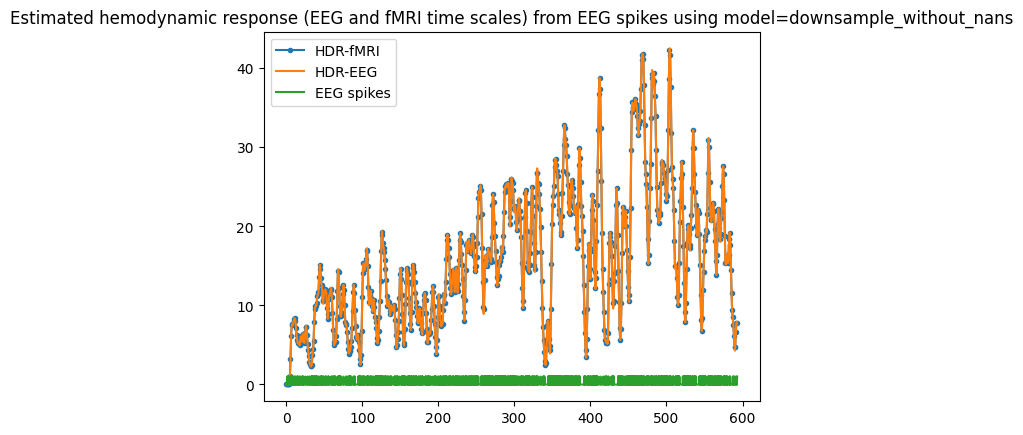

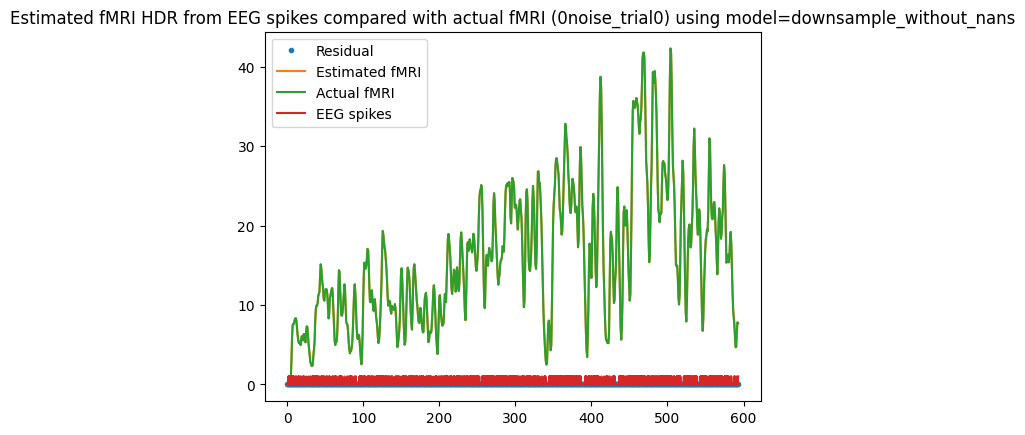

Residual Variance is 0.000000


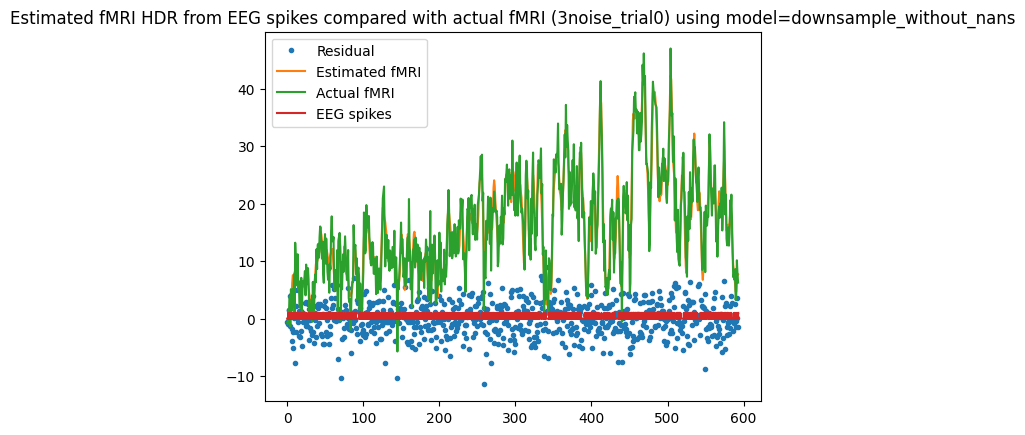

Residual Variance is 8.952240


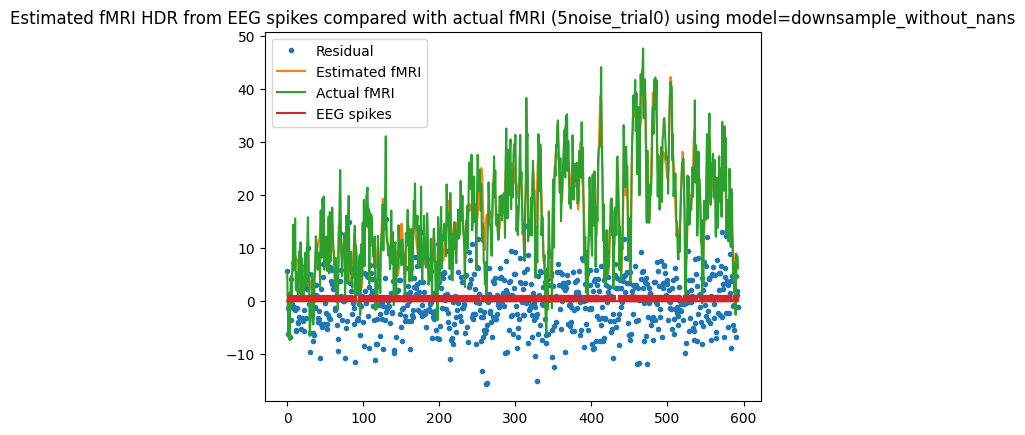

Residual Variance is 24.751680


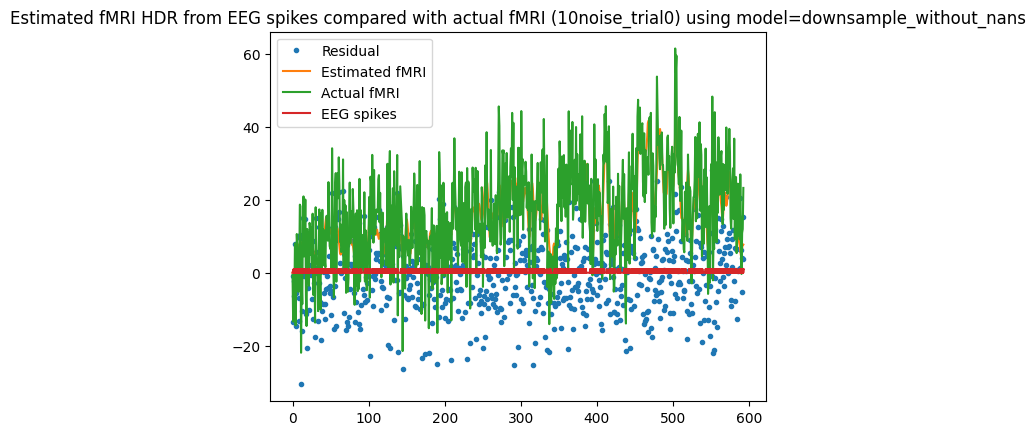

Residual Variance is 99.805850


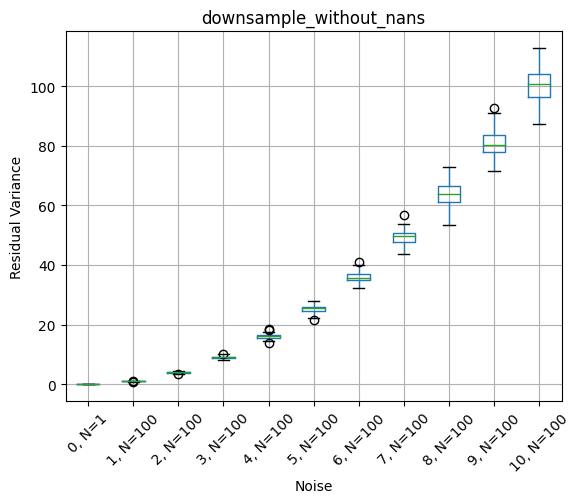

Scoring downsample_with_nans delta=2.25, tau=1.25, alpha=2


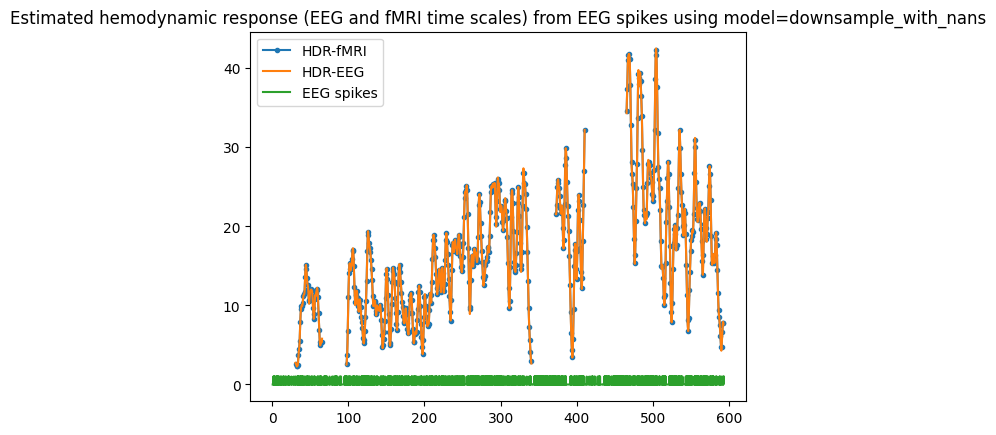

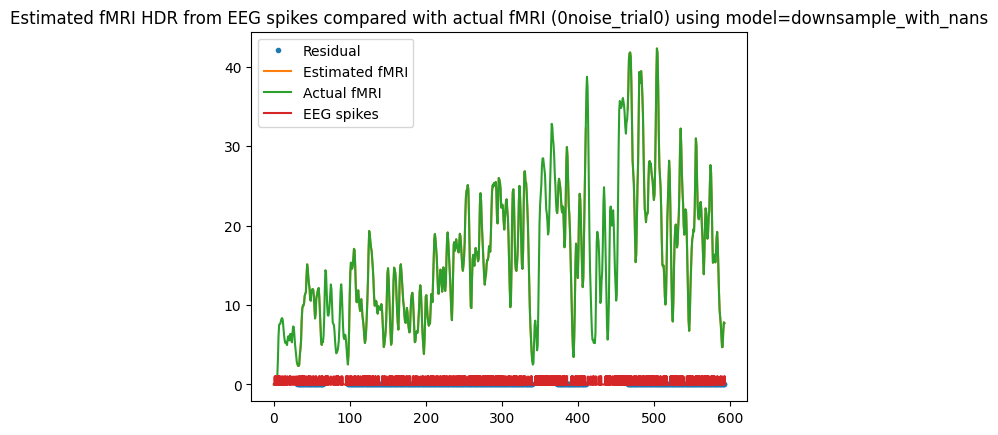

Residual Variance is 0.000000


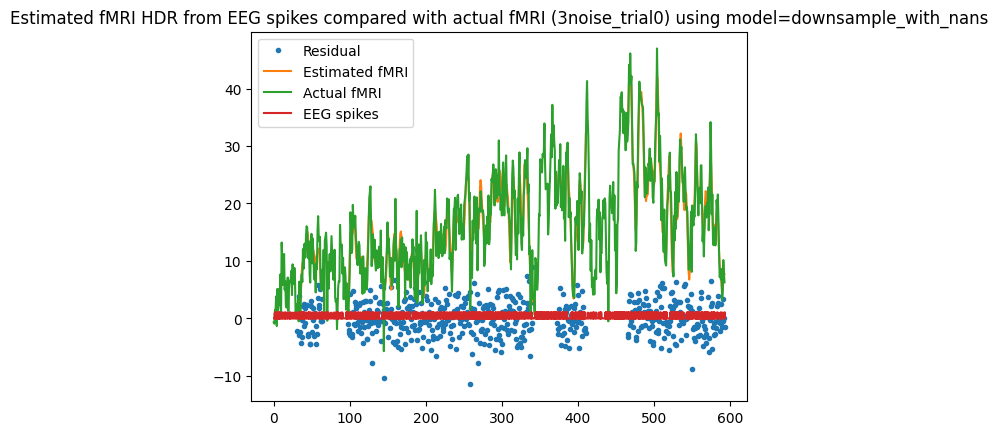

Residual Variance is 8.910483


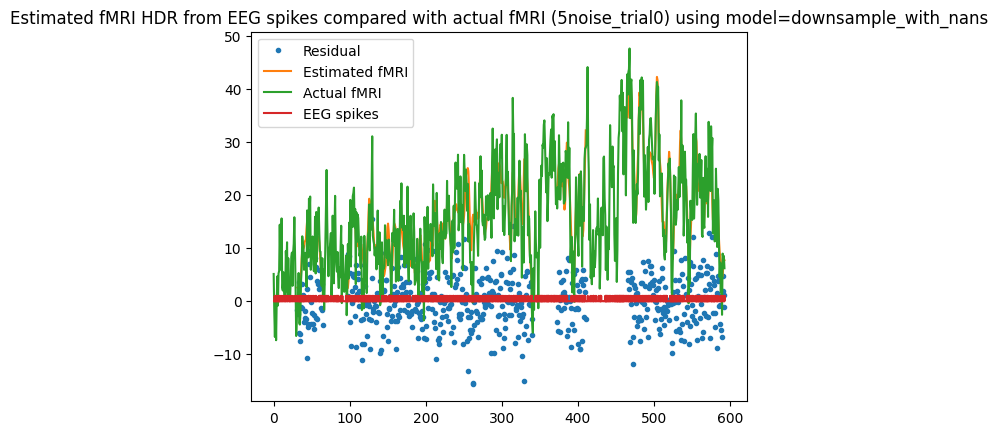

Residual Variance is 24.230559


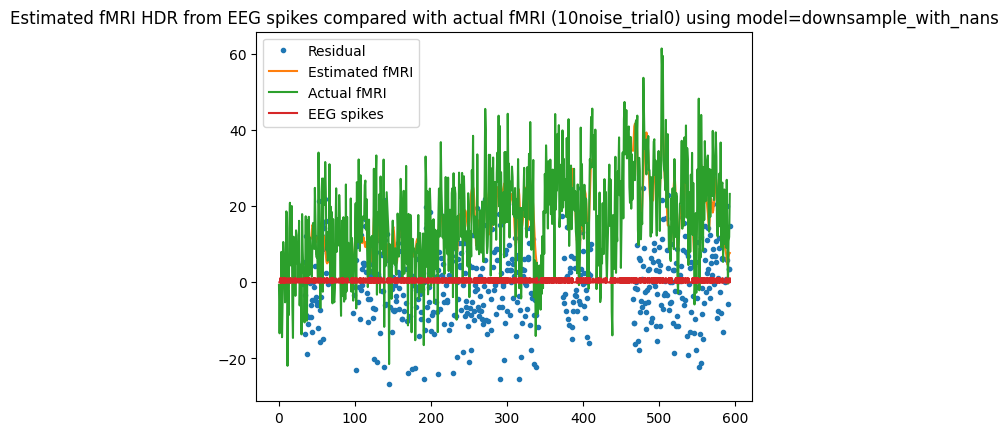

Residual Variance is 100.001349


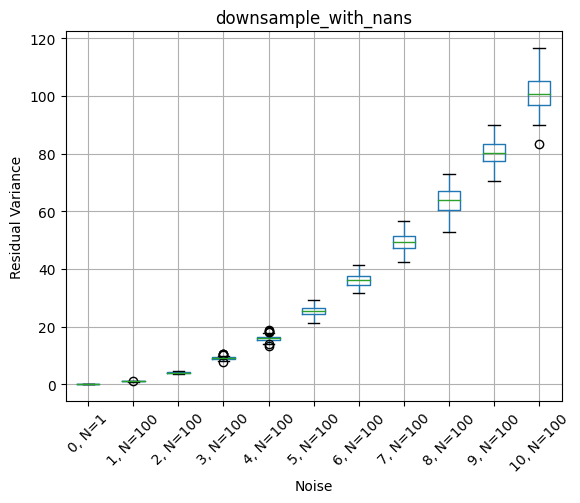

In [9]:
# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False


## Generate/Load the full dataset

In [10]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [11]:
if df.empty:
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)



Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans) = 1.766635050255976e-28; at
       delta   tau  alpha
11780   2.25  1.25    2.0


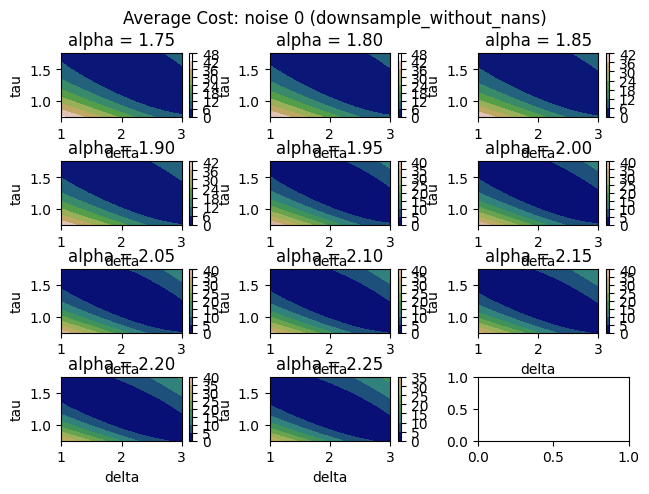

delta   tau  alpha  Average Cost: noise 0 (downsample_without_nans)
0        1.0  0.75   1.75                                        43.017811
2        1.0  0.75   1.80                                        42.164123
4        1.0  0.75   1.85                                        41.301824
6        1.0  0.75   1.90                                        40.431612
8        1.0  0.75   1.95                                        39.554209
...      ...   ...    ...                                              ...
18932    3.0  1.75   2.05                                        13.612216
18934    3.0  1.75   2.10                                        14.401818
18936    3.0  1.75   2.15                                        15.190117
18938    3.0  1.75   2.20                                        15.975699
18940    3.0  1.75   2.25                                        16.757261

[9471 rows x 4 columns]

In [12]:
model_name = 'downsample_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [13]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0   2.25  1.25    2.0

### Local Minima Analysis

In [14]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.352722e-03   2.20  1.20   2.15
1      0         0  1.766635e-28   2.25  1.25   2.00
2      0         0  5.338736e-03   2.30  1.30   1.85

In [15]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [16]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [20]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [21]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_with_nans) = 7.74705274158201e-28; at
       delta   tau  alpha
11781   2.25  1.25    2.0


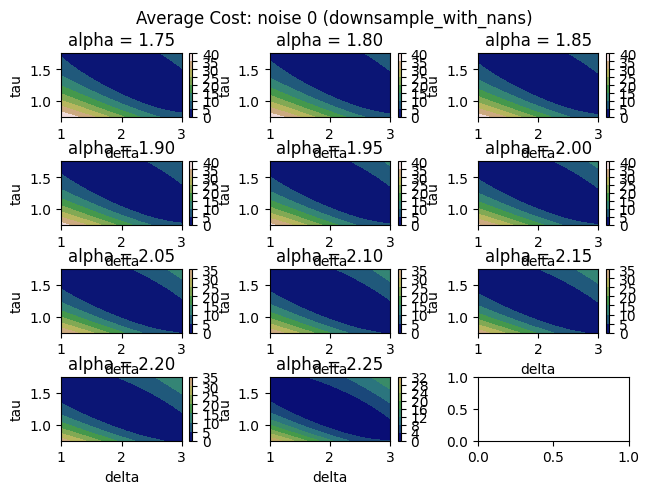

delta   tau  alpha  Average Cost: noise 0 (downsample_with_nans)
1        1.0  0.75   1.75                                     39.269201
3        1.0  0.75   1.80                                     38.539250
5        1.0  0.75   1.85                                     37.799030
7        1.0  0.75   1.90                                     37.049107
9        1.0  0.75   1.95                                     36.290082
...      ...   ...    ...                                           ...
18933    3.0  1.75   2.05                                     12.505089
18935    3.0  1.75   2.10                                     13.208002
18937    3.0  1.75   2.15                                     13.906968
18939    3.0  1.75   2.20                                     14.600698
18941    3.0  1.75   2.25                                     15.288021

[9471 rows x 4 columns]

In [22]:
model_name = 'downsample_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [23]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0   2.25  1.25    2.0

### Local Minima Analysis

In [24]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.288068e-03   2.20  1.20   2.15
1      0         0  7.747053e-28   2.25  1.25   2.00
2      0         0  5.361413e-03   2.30  1.30   1.85

In [25]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [26]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [30]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [31]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans) = 0.9938649086802194; at
       delta   tau  alpha
11780   2.25  1.25    2.0


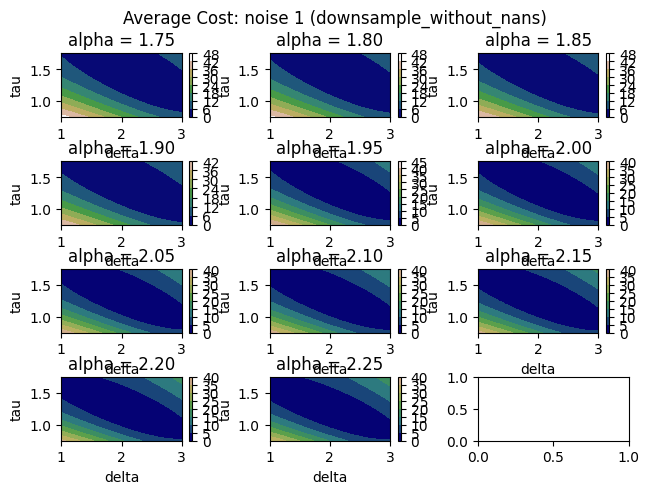

Minimal Cost for Average Cost: noise 2 (downsample_without_nans) = 4.003729197655309; at
       delta   tau  alpha
11780   2.25  1.25    2.0


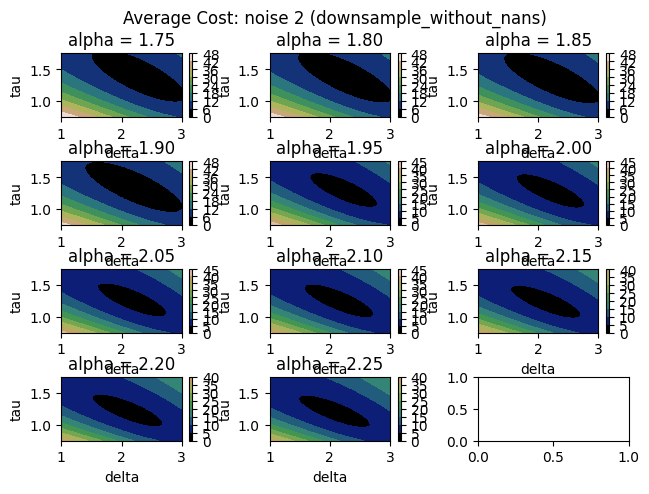

Minimal Cost for Average Cost: noise 3 (downsample_without_nans) = 8.998884543516642; at
       delta   tau  alpha
11780   2.25  1.25    2.0


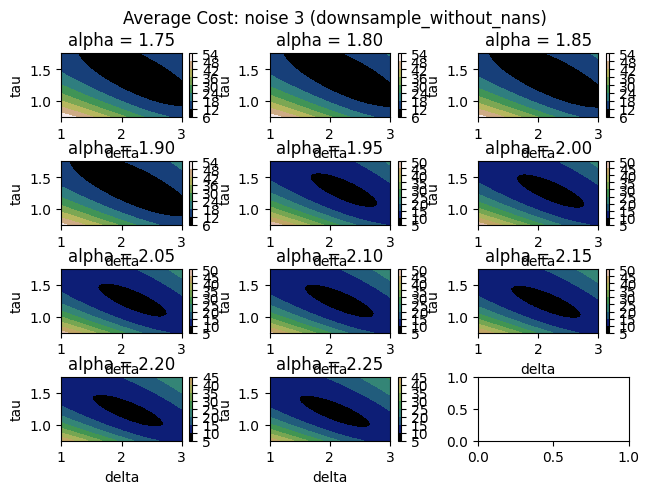

Minimal Cost for Average Cost: noise 4 (downsample_without_nans) = 16.040119989963713; at
       delta   tau  alpha
11780   2.25  1.25    2.0


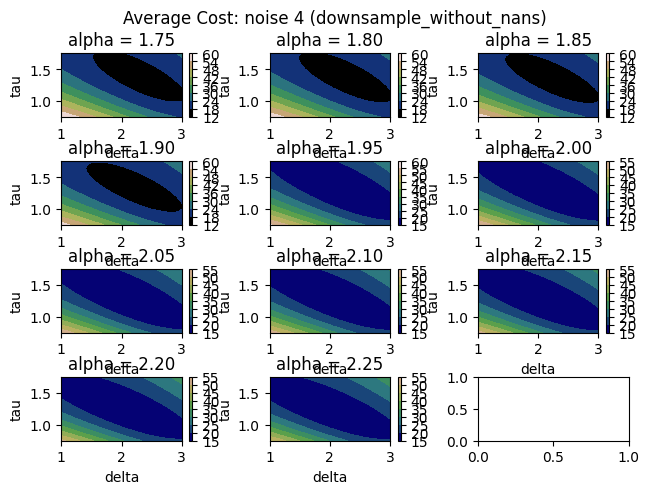

Minimal Cost for Average Cost: noise 5 (downsample_without_nans) = 25.25868864467434; at
       delta   tau  alpha
11320    2.2  1.25   2.05


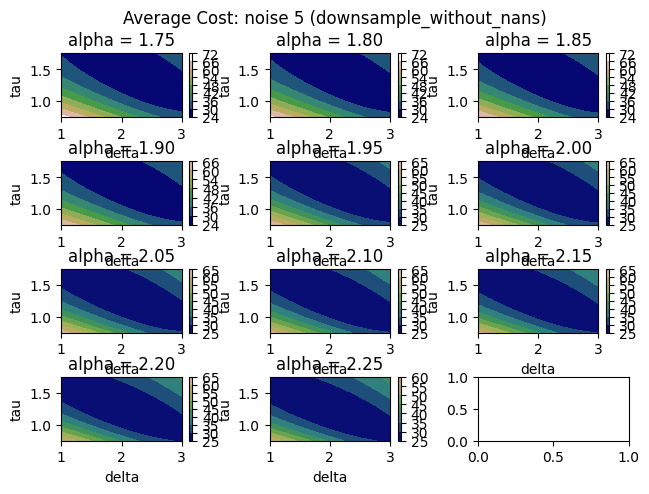

Minimal Cost for Average Cost: noise 6 (downsample_without_nans) = 35.85551031478898; at
       delta   tau  alpha
11780   2.25  1.25    2.0


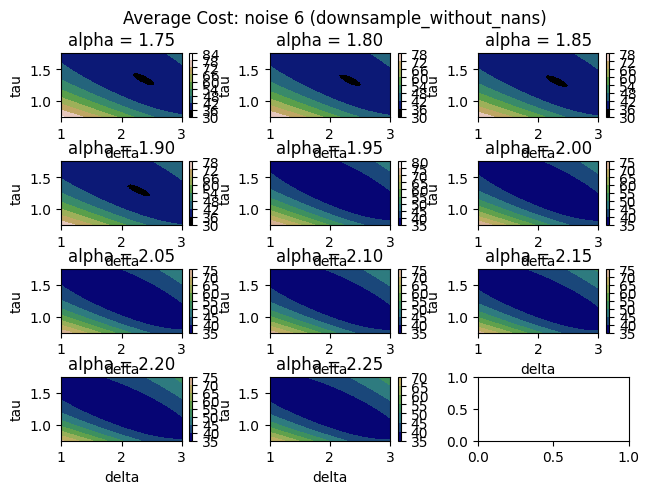

Minimal Cost for Average Cost: noise 7 (downsample_without_nans) = 49.32739494744689; at
       delta   tau  alpha
11780   2.25  1.25    2.0


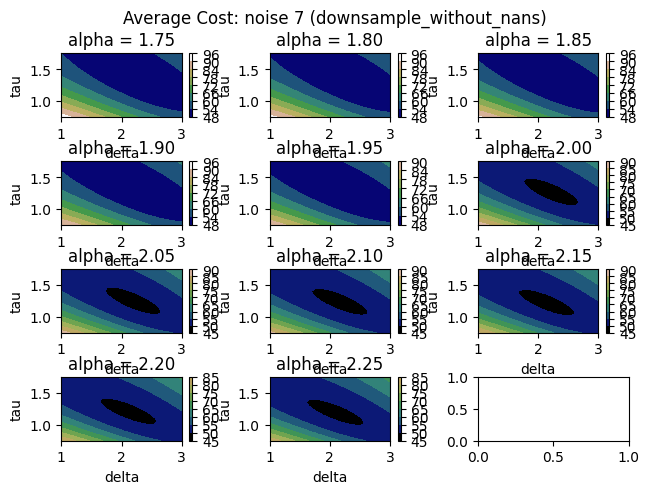

Minimal Cost for Average Cost: noise 8 (downsample_without_nans) = 63.654735239148025; at
       delta   tau  alpha
12240    2.3  1.25   1.95


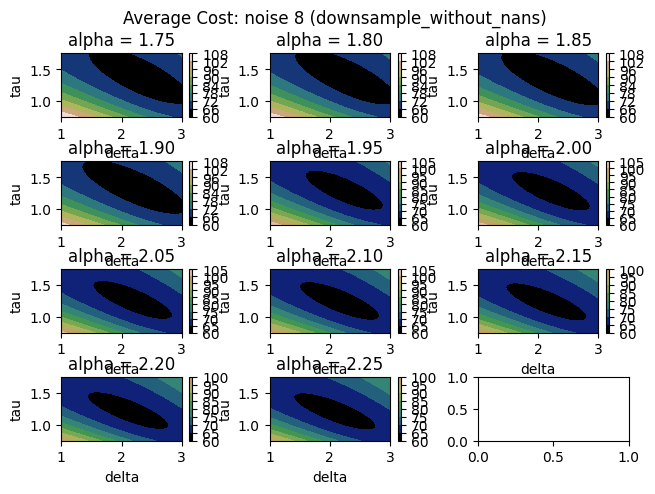

Minimal Cost for Average Cost: noise 9 (downsample_without_nans) = 80.80411199700703; at
       delta  tau  alpha
12258    2.3  1.3   1.85


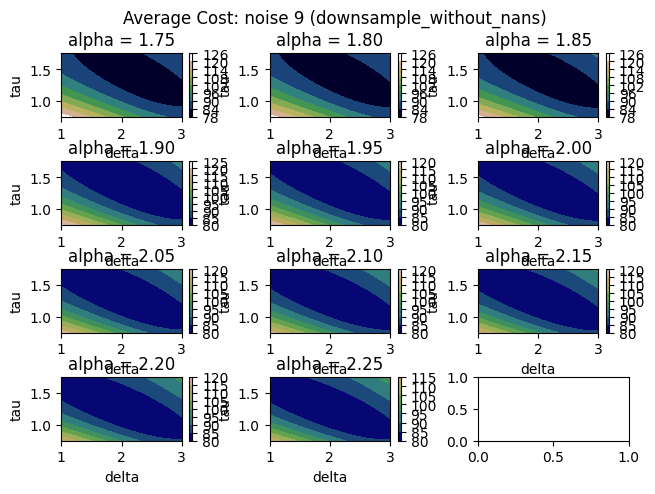

Minimal Cost for Average Cost: noise 10 (downsample_without_nans) = 100.53263261609378; at
       delta   tau  alpha
11780   2.25  1.25    2.0


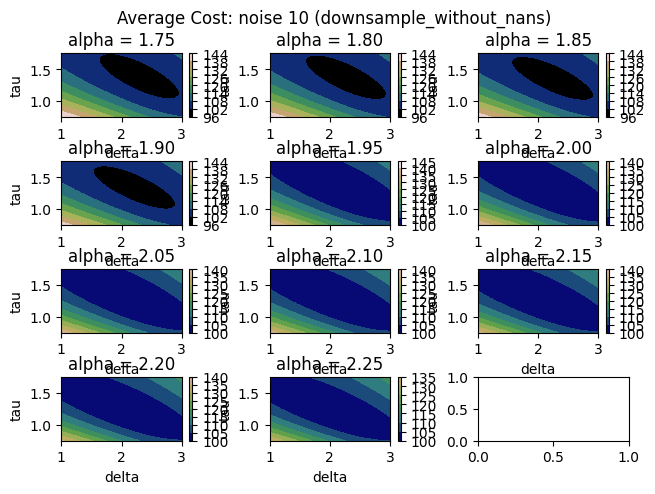

In [32]:
model_name = 'downsample_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

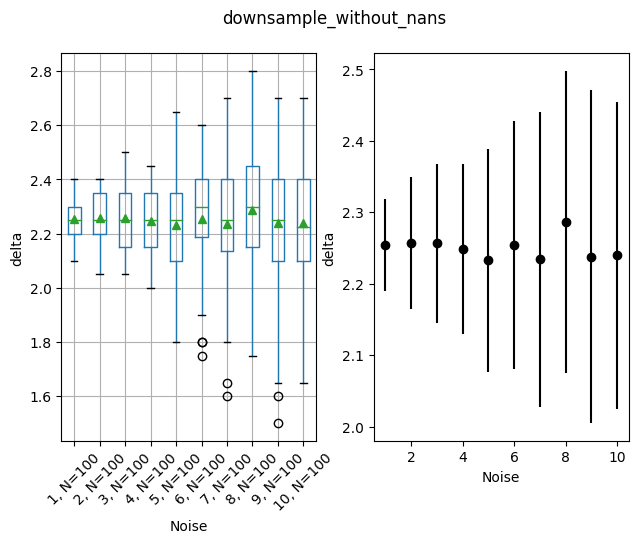

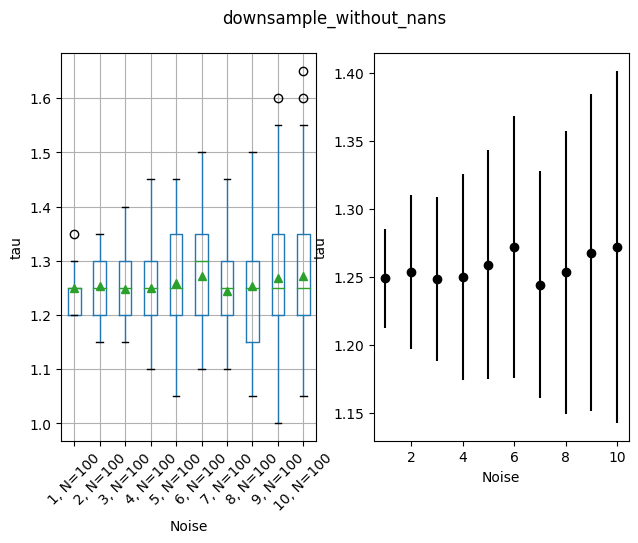

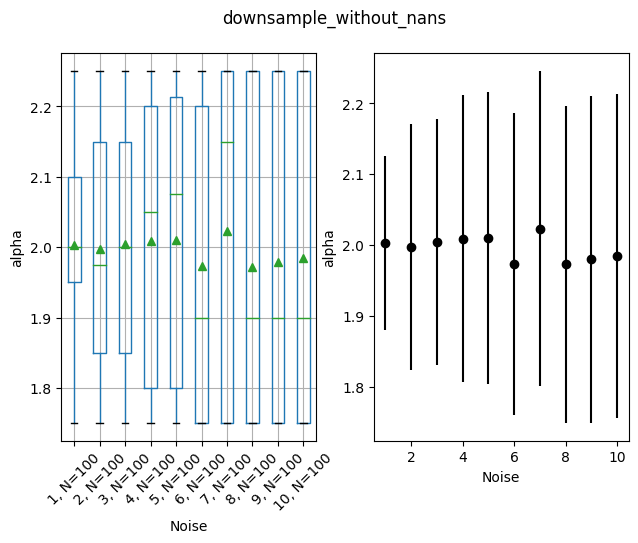

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans) = 0.9938649086802194; at
       delta   tau  alpha
11780   2.25  1.25    2.0


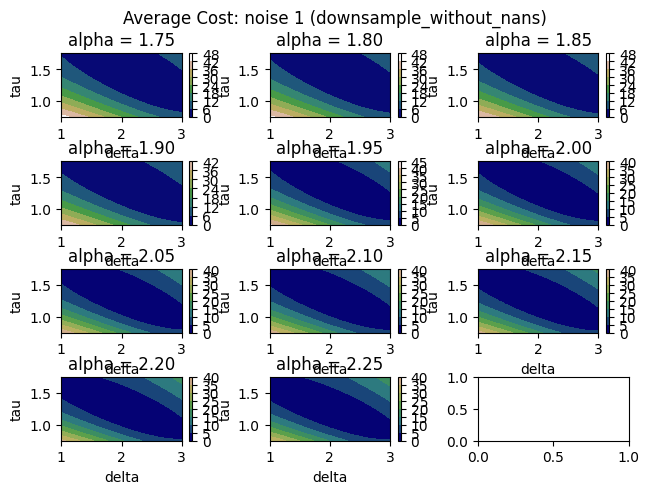

Minimal Cost for Average Cost: noise 2 (downsample_without_nans) = 4.003729197655309; at
       delta   tau  alpha
11780   2.25  1.25    2.0


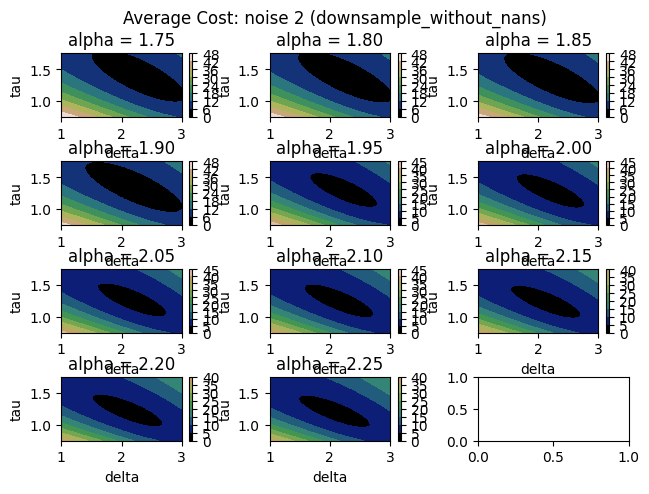

Minimal Cost for Average Cost: noise 3 (downsample_without_nans) = 8.998884543516642; at
       delta   tau  alpha
11780   2.25  1.25    2.0


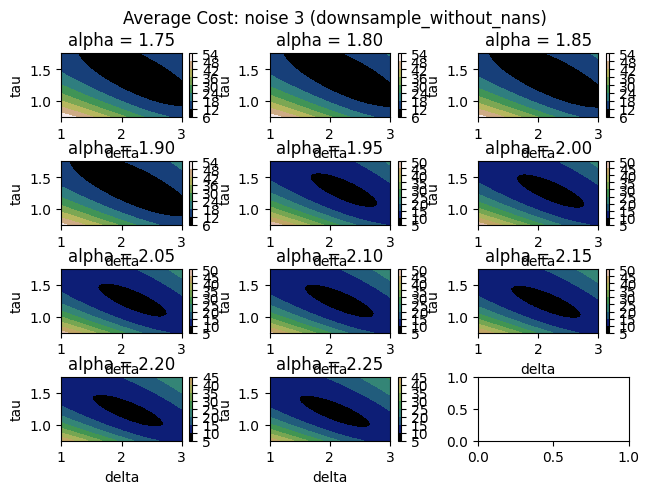

Minimal Cost for Average Cost: noise 4 (downsample_without_nans) = 16.040119989963713; at
       delta   tau  alpha
11780   2.25  1.25    2.0


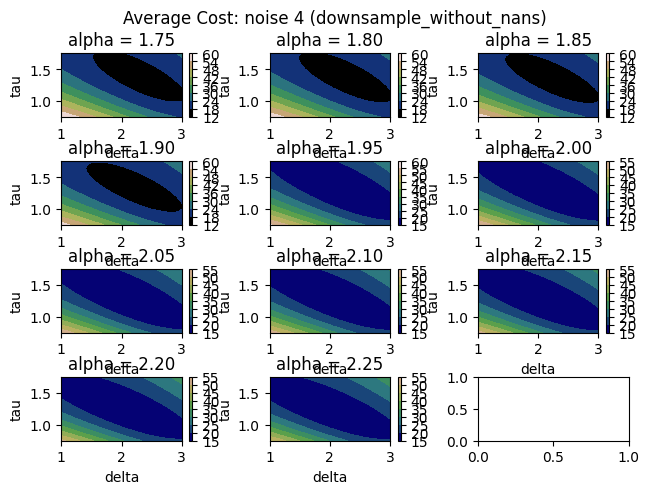

Minimal Cost for Average Cost: noise 5 (downsample_without_nans) = 25.25868864467434; at
       delta   tau  alpha
11320    2.2  1.25   2.05


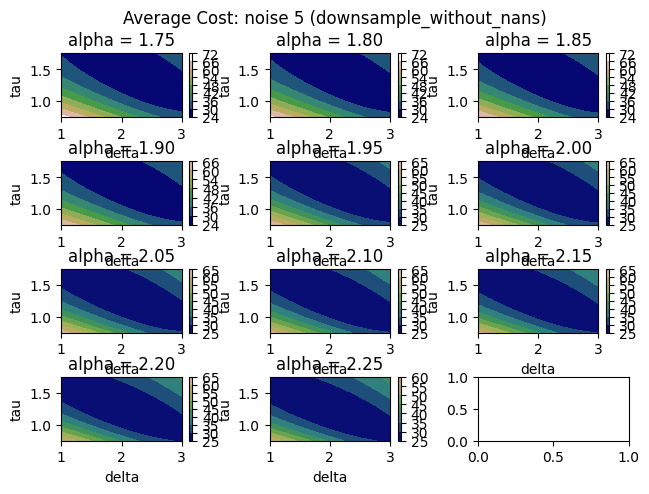

Minimal Cost for Average Cost: noise 6 (downsample_without_nans) = 35.85551031478898; at
       delta   tau  alpha
11780   2.25  1.25    2.0


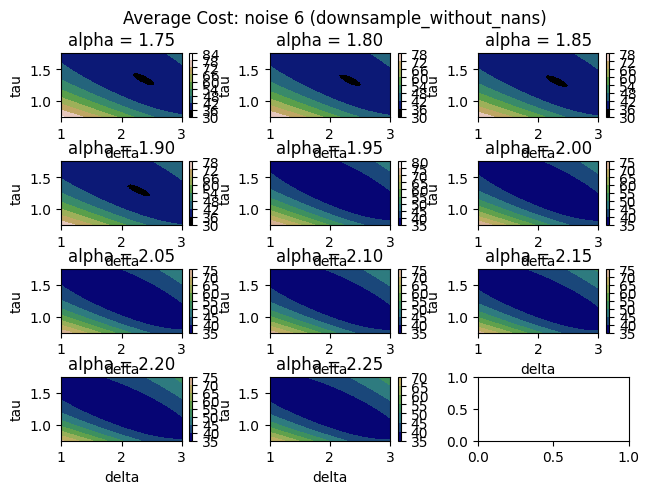

Minimal Cost for Average Cost: noise 7 (downsample_without_nans) = 49.32739494744689; at
       delta   tau  alpha
11780   2.25  1.25    2.0


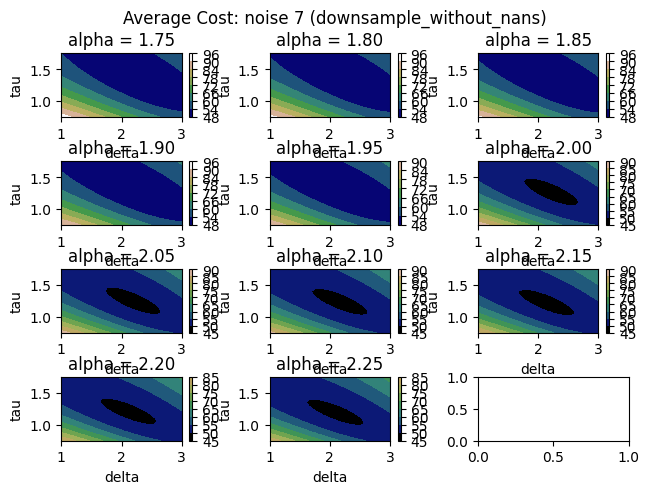

Minimal Cost for Average Cost: noise 8 (downsample_without_nans) = 63.654735239148025; at
       delta   tau  alpha
12240    2.3  1.25   1.95


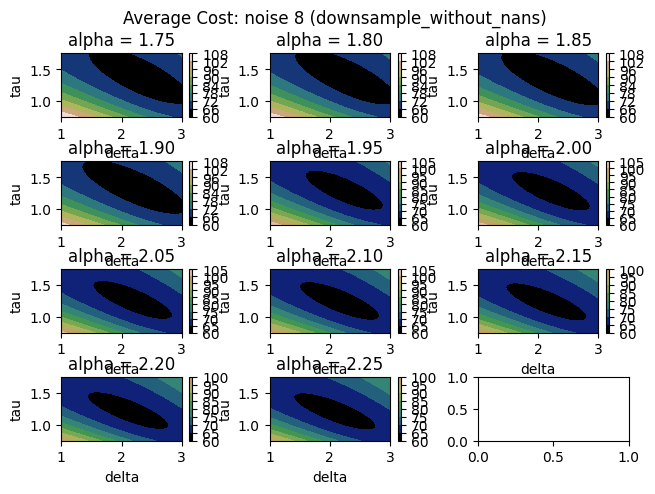

Minimal Cost for Average Cost: noise 9 (downsample_without_nans) = 80.80411199700703; at
       delta  tau  alpha
12258    2.3  1.3   1.85


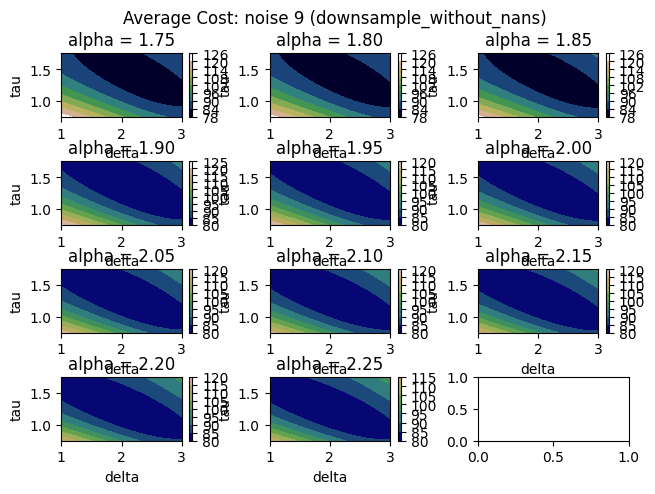

Minimal Cost for Average Cost: noise 10 (downsample_without_nans) = 100.53263261609378; at
       delta   tau  alpha
11780   2.25  1.25    2.0


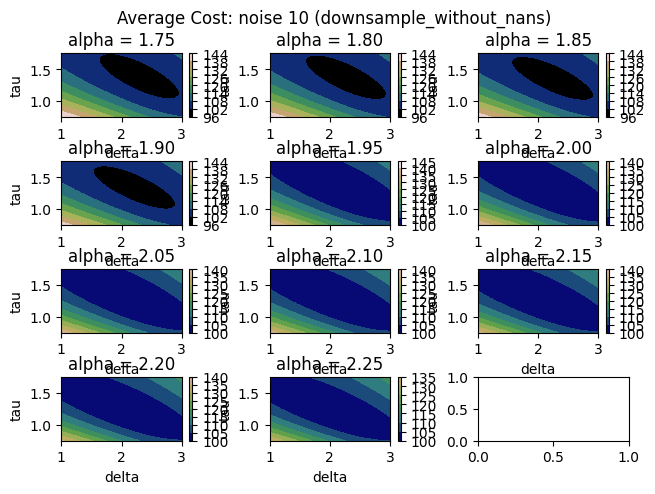

In [34]:
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


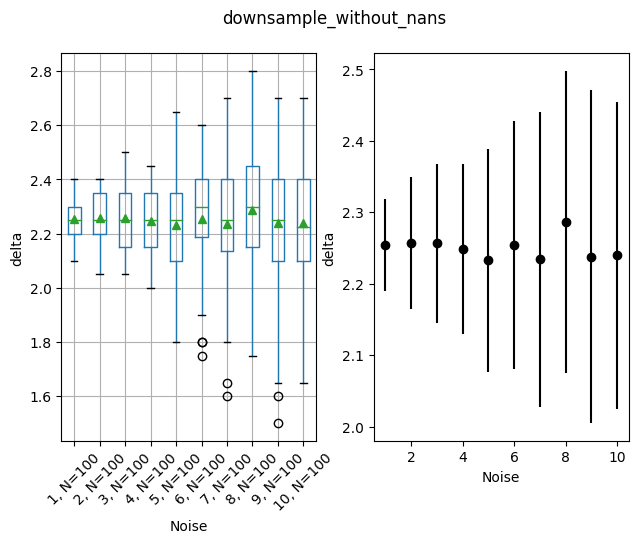

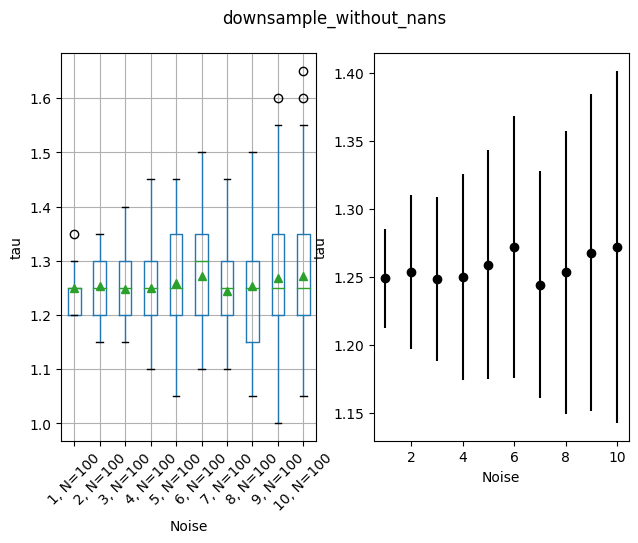

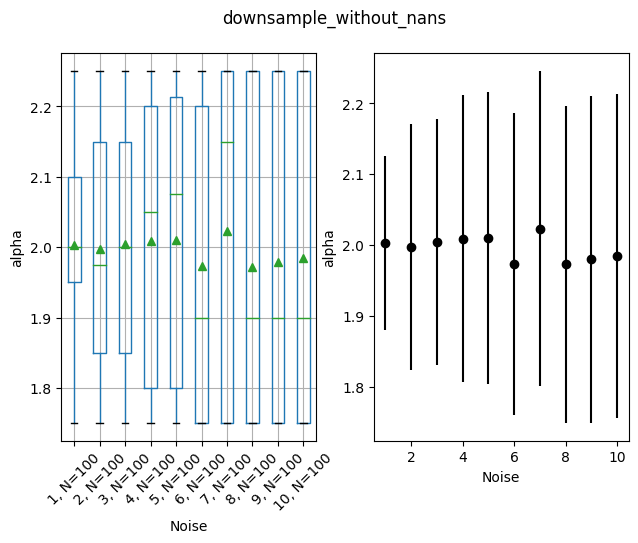

In [35]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [36]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans'


In [37]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [38]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        12    0.961367   2.100000000000001  1.2000000000000004   
1         1        44    0.998839   2.100000000000001  1.2000000000000004   
2         1        19    0.931842   2.100000000000001  1.2000000000000004   
3         1        56    0.998928   2.100000000000001  1.2000000000000004   
4         1        65    0.974368   2.100000000000001  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2688     10        23   96.054566  2.6000000000000014  1.2500000000000004   
2689     10        91  102.420652  2.6500000000000012  1.3500000000000005   
2690     10        63   95.582207  2.7000000000000015  1.1500000000000004   
2691     10        38  105.609821  2.7000000000000015  1.1500000000000004   
2692     10        28   96.141385  2.7000000000000015  1.2000000000000004   

                   alpha  
0                    2.2  
1                    2.2  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2688                1.75  
2689                1.75  
2690                1.75  
2691                 1.8  
2692                1.75  

[2693 rows x 6 columns]

In [39]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
1                        3.27
2                        3.38
3                        3.14
4                        2.95
5                        2.72
6                        2.37
7                        2.39
8                        2.27
9                        2.22
10                       2.22

#### Local minima at edges

In [40]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [43]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [44]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
291       1         6    1.039033  2.3500000000000014  1.3500000000000005   
292       1         9    1.076576  2.3500000000000014  1.3500000000000005   
293       1        11    1.012464  2.3500000000000014  1.3500000000000005   
294       1        14    1.072422  2.3500000000000014  1.3500000000000005   
295       1        16    1.017276  2.3500000000000014  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
2686     10        22  106.610478  2.6000000000000014  1.2000000000000004   
2688     10        23   96.054566  2.6000000000000014  1.2500000000000004   
2689     10        91  102.420652  2.6500000000000012  1.3500000000000005   
2690     10        63   95.582207  2.7000000000000015  1.1500000000000004   
2692     10        28   96.141385  2.7000000000000015  1.2000000000000004   

     alpha  
291   1.75  
292   1.75  
293   1.75  
294   1.75  
295   1.75  
...    ...  
2686  1.75  
2688  1.75  
2689  1.75  
2690  1.75  
2692  1.75  

[400 rows x 6 columns]

In [45]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        25      2  2.3500000000000014   24    25      1  1.3500000000000005   
10       49     16  2.4000000000000012   11    49     12  1.3000000000000005   
2        38      4  2.3500000000000014   17    38      2  1.3500000000000005   
3        33      5  2.3500000000000014   10    33      3  1.3500000000000005   
4        37      7  2.3500000000000014   11    37      4  1.3000000000000005   
5        35      8   2.300000000000001    7    35      6  1.3000000000000005   
6        50      9  2.4000000000000012   13    50      7  1.3000000000000005   
7        38     10  2.4000000000000012    8    38      6  1.3000000000000005   
8        48     12  2.5000000000000013    9    48      8  1.3500000000000005   
9        47     16  2.3500000000000014    8    47     10  1.3000000000000005   

            
      freq  
noise       
1       25  
10      10  
2       25  
3       18  
4       17  
5       12  
6       14  
7       14  
8       10  
9       13

In [46]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
2         1        19    0.931842   2.100000000000001  1.2000000000000004   
3         1        56    0.998928   2.100000000000001  1.2000000000000004   
4         1        65    0.974368   2.100000000000001  1.2000000000000004   
46        1        43    1.026044   2.200000000000001  1.1500000000000004   
47        1        48    0.968169   2.200000000000001  1.1500000000000004   
...     ...       ...         ...                 ...                 ...   
2633     10        24   99.156737  2.4000000000000012  0.9500000000000002   
2634     10         4   90.888123  2.4000000000000012  1.0500000000000003   
2635     10        23   96.039652  2.4000000000000012  1.1000000000000003   
2660     10        63   95.554750  2.5000000000000013  1.0000000000000002   
2665     10        88  107.412773  2.5000000000000013  1.0500000000000003   

                   alpha  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
46    2.2500000000000004  
47    2.2500000000000004  
...                  ...  
2633  2.2500000000000004  
2634  2.2500000000000004  
2635  2.2500000000000004  
2660  2.2500000000000004  
2665  2.2500000000000004  

[390 rows x 6 columns]

In [47]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1         6      2   2.100000000000001    3     6      2  1.2000000000000004   
10       52     15   2.100000000000001    8    52     10  1.2000000000000004   
2        40      5   2.100000000000001   11    40      2  1.2000000000000004   
3        35      5   2.100000000000001    9    35      4  1.1500000000000004   
4        42      8  2.1500000000000012   11    42      4  1.1500000000000004   
5        46     11   2.000000000000001    9    46      5  1.1500000000000004   
6        37     11   2.200000000000001    9    37      6  1.2000000000000004   
7        44     16   2.000000000000001    7    44      7  1.1500000000000004   
8        42     16  2.1500000000000012    6    42      6  1.1500000000000004   
9        46     19  2.0500000000000007    6    46      9  1.2000000000000004   

            
      freq  
noise       
1        3  
10      14  
2       21  
3       18  
4       29  
5       19  
6       13  
7       12  
8       14  
9       11

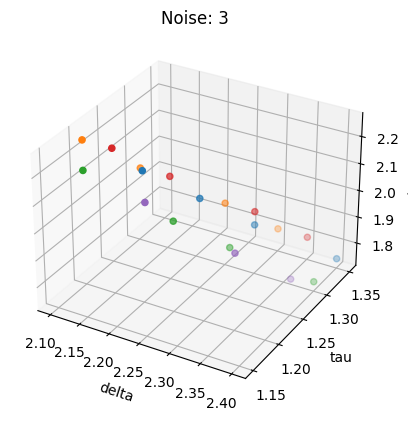

In [48]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

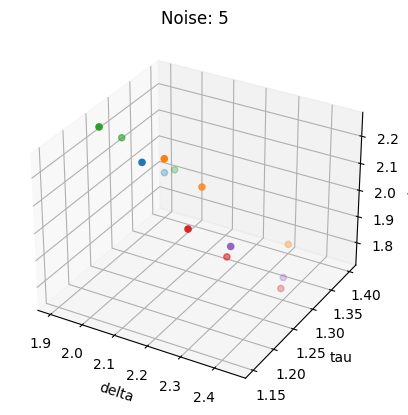

In [49]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

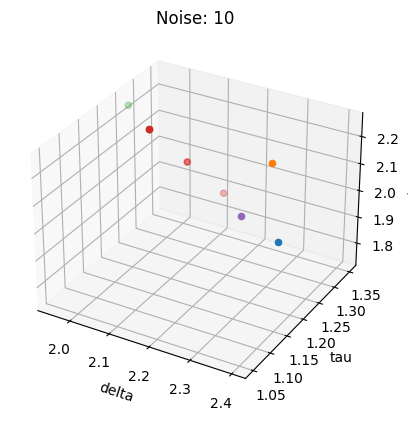

In [50]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [51]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_with_nans'


In [52]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [53]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        12    1.006579   2.100000000000001  1.2000000000000004   
1         1        44    0.997419   2.100000000000001  1.2000000000000004   
2         1        65    0.994988   2.100000000000001  1.2000000000000004   
3         1        14    1.048601   2.100000000000001  1.2000000000000004   
4         1        30    0.910999   2.100000000000001  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2558     10        56  101.098513  2.7000000000000015  1.0000000000000002   
2559     10        46  100.975849  2.7000000000000015  1.1000000000000003   
2560     10         7   97.130249  2.7500000000000018  1.2000000000000004   
2561     10         7   97.128983  2.7500000000000018  1.2500000000000004   
2562     10        91  107.010519  2.7500000000000018  1.3000000000000005   

                   alpha  
0                    2.2  
1                    2.2  
2                    2.2  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2558                1.75  
2559                 1.8  
2560                1.85  
2561                1.75  
2562                1.75  

[2563 rows x 6 columns]

In [54]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
1                        3.39
2                        3.28
3                        3.01
4                        2.81
5                        2.34
6                        2.25
7                        2.31
8                        2.12
9                        2.12
10                       2.00

#### Local minima at edges

In [55]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [58]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [59]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
258       1        12    1.010644   2.300000000000001  1.3500000000000005   
301       1         6    1.038906  2.3500000000000014  1.3500000000000005   
302       1         7    1.032558  2.3500000000000014  1.3500000000000005   
303       1         9    1.025322  2.3500000000000014  1.3500000000000005   
304       1        16    1.048088  2.3500000000000014  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
2556     10        93   97.709803  2.6500000000000012  1.1000000000000003   
2557     10        22  105.333669  2.6500000000000012  1.2500000000000004   
2558     10        56  101.098513  2.7000000000000015  1.0000000000000002   
2561     10         7   97.128983  2.7500000000000018  1.2500000000000004   
2562     10        91  107.010519  2.7500000000000018  1.3000000000000005   

     alpha  
258   1.75  
301   1.75  
302   1.75  
303   1.75  
304   1.75  
...    ...  
2556  1.75  
2557  1.75  
2558  1.75  
2561  1.75  
2562  1.75  

[429 rows x 6 columns]

In [60]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        32      3  2.3500000000000014   26    32      2  1.3500000000000005   
10       51     15  2.5000000000000013    9    51     14  1.3000000000000005   
2        34      4  2.4000000000000012   16    34      3  1.3500000000000005   
3        40      7  2.3500000000000014    9    40      4  1.3500000000000005   
4        41      8  2.3500000000000014   13    41      6  1.3500000000000005   
5        33      9  2.3500000000000014    9    33      7  1.3500000000000005   
6        59     13   2.300000000000001   10    59      7  1.3500000000000005   
7        44     14  2.4000000000000012    6    44      9  1.2500000000000004   
8        45     14  2.4000000000000012    8    45      9  1.3000000000000005   
9        50     16  2.3500000000000014    8    50     11  1.3000000000000005   

            
      freq  
noise       
1       31  
10      11  
2       16  
3       18  
4       15  
5        8  
6       15  
7       12  
8       15  
9        8

In [61]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
3         1        14    1.048601   2.100000000000001  1.2000000000000004   
4         1        30    0.910999   2.100000000000001  1.2000000000000004   
5         1        56    1.065079   2.100000000000001  1.2000000000000004   
6         1        96    0.971975   2.100000000000001  1.2000000000000004   
7         1        35    1.023621  2.1500000000000012  1.1500000000000004   
...     ...       ...         ...                 ...                 ...   
2500     10         8   96.987574  2.4000000000000012  1.0500000000000003   
2501     10        88  106.200969  2.4000000000000012  1.0500000000000003   
2513     10         4   93.547746   2.450000000000001  1.0000000000000002   
2517     10        28   97.388871   2.450000000000001  1.1500000000000004   
2524     10        88  106.195823  2.5000000000000013  1.0000000000000002   

                   alpha  
3     2.2500000000000004  
4     2.2500000000000004  
5     2.2500000000000004  
6     2.2500000000000004  
7     2.2500000000000004  
...                  ...  
2500  2.2500000000000004  
2501  2.2500000000000004  
2513  2.2500000000000004  
2517  2.2500000000000004  
2524  2.2500000000000004  

[369 rows x 6 columns]

In [62]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        14      3   2.200000000000001    7    14      2  1.1500000000000004   
10       44     17  2.0500000000000007    9    44     10  1.1500000000000004   
2        32      5   2.100000000000001   10    32      2  1.1500000000000004   
3        46      7  2.1500000000000012   13    46      4  1.2000000000000004   
4        34     10   2.200000000000001    8    34      5  1.1500000000000004   
5        35     11  1.9500000000000008    6    35      5  1.2000000000000004   
6        42     13   2.300000000000001    7    42      7  1.1500000000000004   
7        46     15   2.100000000000001    7    46      8  1.2000000000000004   
8        37     16  2.1500000000000012    5    37      7  1.1000000000000003   
9        39     15  1.9000000000000008    6    39      9  1.2500000000000004   

            
      freq  
noise       
1        9  
10      11  
2       17  
3       19  
4       14  
5       14  
6       15  
7       10  
8       10  
9       11

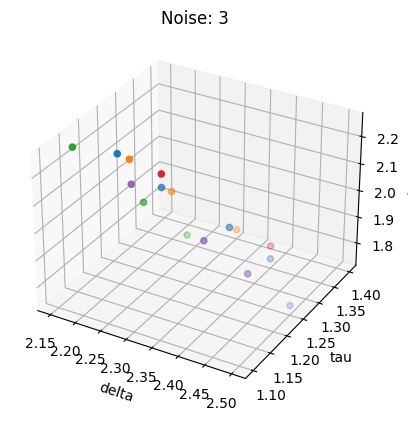

In [63]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

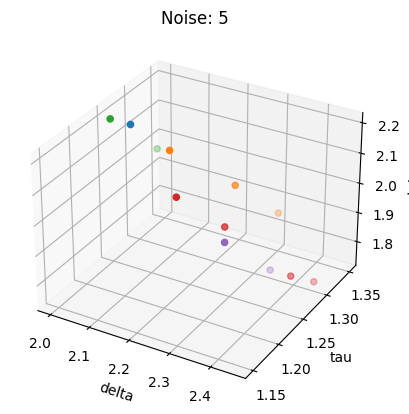

In [64]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

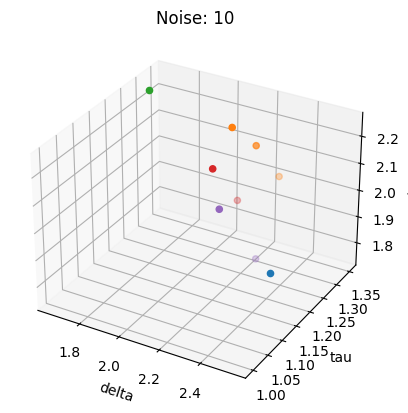

In [65]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()